In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Successfully loaded data from Google Drive

Training model with Grid Search...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'lbfgs'}

Training Metrics:
Accuracy: 0.3061
Precision: 0.6162
Recall: 0.3061
F1 Score: 0.3717

Testing Metrics:
Accuracy: 0.2936
Precision: 0.5915
Recall: 0.2936
F1 Score: 0.3572

Classification Report:
                 precision    recall  f1-score   support

         Normal       0.73      0.28      0.41      7899
Moderate Stress       0.19      0.31      0.23      2065
     Depression       0.05      0.40      0.09       553

       accuracy                           0.29     10517
      macro avg       0.33      0.33      0.25     10517
   weighted avg       0.59      0.29      0.36     10517



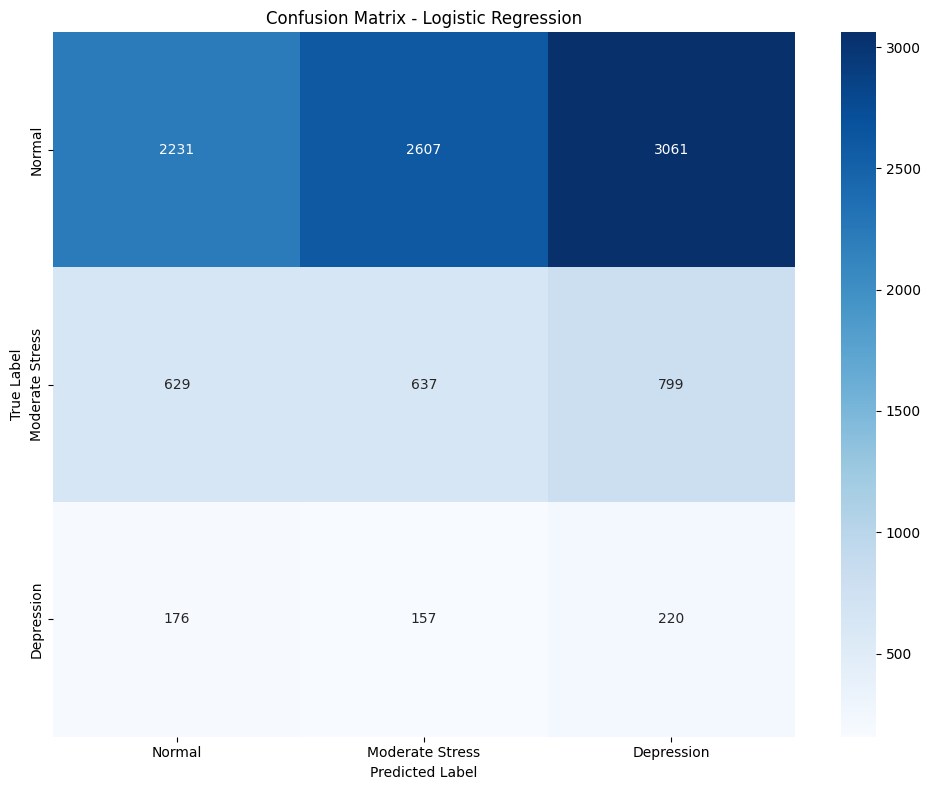

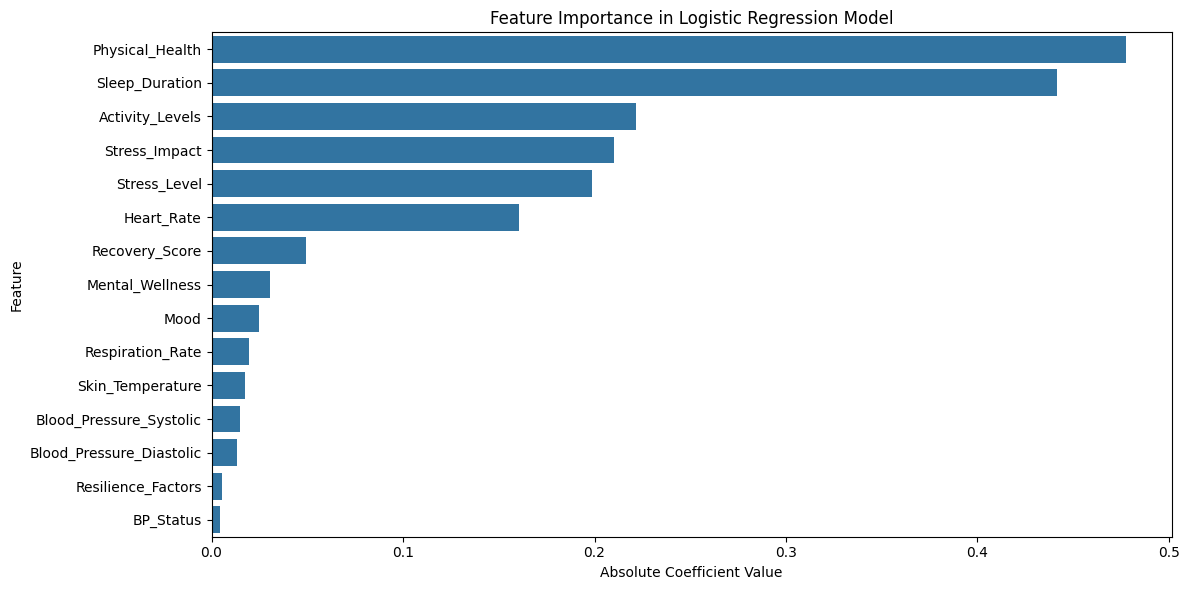


Model and scaler saved successfully


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
try:
    cleaned_dataset_path = '/content/drive/My Drive/ML/new.csv'
    cleaned_data = pd.read_csv(cleaned_dataset_path)
    print("Successfully loaded data from Google Drive")
except:
    try:
        cleaned_data = pd.read_csv('new.csv')
        print("Successfully loaded data from local directory")
    except:
        print("Error: Could not load the dataset.")
        raise

# Define features and target
features = [
    'Heart_Rate',
    'Blood_Pressure_Systolic',
    'Blood_Pressure_Diastolic',
    'Skin_Temperature',
    'Respiration_Rate',
    'Sleep_Duration',
    'Activity_Levels',
    'Mood',
    'Stress_Level',
    'Resilience_Factors'
]
target = 'Mental_Health_Status'

def create_features(df):
    """Create effective features for mental health prediction"""
    result = df.copy()

    # Health Indices
    result['Mental_Wellness'] = (
        df['Mood'] * 0.4 +
        df['Resilience_Factors'] * 0.3 +
        (10 - df['Stress_Level']) * 0.3
    )

    result['Physical_Health'] = (
        df['Activity_Levels'] * 0.4 +
        (df['Sleep_Duration'] / 8) * 0.3 +
        (1 - abs(df['Heart_Rate'] - 70) / 100) * 0.3
    ) * 10

    result['Recovery_Score'] = (
        df['Sleep_Duration'] * df['Resilience_Factors']
    ) / (df['Stress_Level'].replace(0, 1))

    # Risk Indicators
    result['Stress_Impact'] = (
        df['Stress_Level'] * (10 - df['Sleep_Duration'] / 2.4)
    ) / 10

    result['BP_Status'] = (
        df['Blood_Pressure_Systolic'] / 120 +
        df['Blood_Pressure_Diastolic'] / 80
    ) / 2 * 10

    return result

def preprocess_data(df, features):
    """Preprocess data with optimal ranges"""
    processed = df.copy()

    # Fill missing values with median
    for col in features:
        processed[col] = processed[col].fillna(processed[col].median())

    # Clip values to reasonable ranges
    ranges = {
        'Heart_Rate': (40, 180),
        'Blood_Pressure_Systolic': (90, 180),
        'Blood_Pressure_Diastolic': (60, 120),
        'Skin_Temperature': (35, 38),
        'Respiration_Rate': (8, 30),
        'Sleep_Duration': (0, 12),
        'Activity_Levels': (0, 10),
        'Mood': (0, 10),
        'Stress_Level': (0, 10),
        'Resilience_Factors': (0, 10)
    }

    for col, (min_val, max_val) in ranges.items():
        if col in processed.columns:
            processed[col] = processed[col].clip(min_val, max_val)

    # Create new features
    processed = create_features(processed)

    return processed

# Preprocess the data
processed_data = preprocess_data(cleaned_data, features)

# Add new features to features list
additional_features = [
    'Mental_Wellness', 'Physical_Health', 'Recovery_Score',
    'Stress_Impact', 'BP_Status'
]
all_features = features + additional_features

# Prepare features and target
X = processed_data[all_features]
y = processed_data[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for balancing classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Define model parameters
param_grid = {
    'C': [0.1, 1, 10],
    'class_weight': ['balanced'],
    'max_iter': [1000],
    'solver': ['lbfgs'],
    'multi_class': ['ovr']
}

# Initialize and perform Grid Search
log_reg = LogisticRegression(random_state=42)
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
print("\nTraining model with Grid Search...")
grid_search.fit(X_train_balanced, y_train_balanced)

# Get best model
best_model = grid_search.best_estimator_
print("\nBest parameters:", grid_search.best_params_)

# Make predictions
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Calculate metrics
metrics_train = {
    "Accuracy": accuracy_score(y_train, y_pred_train),
    "Precision": precision_score(y_train, y_pred_train, average='weighted'),
    "Recall": recall_score(y_train, y_pred_train, average='weighted'),
    "F1 Score": f1_score(y_train, y_pred_train, average='weighted')
}

metrics_test = {
    "Accuracy": accuracy_score(y_test, y_pred_test),
    "Precision": precision_score(y_test, y_pred_test, average='weighted'),
    "Recall": recall_score(y_test, y_pred_test, average='weighted'),
    "F1 Score": f1_score(y_test, y_pred_test, average='weighted')
}

# Print results
print("\nTraining Metrics:")
for metric, value in metrics_train.items():
    print(f"{metric}: {value:.4f}")

print("\nTesting Metrics:")
for metric, value in metrics_test.items():
    print(f"{metric}: {value:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test,
                          target_names=['Normal', 'Moderate Stress', 'Depression']))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Moderate Stress', 'Depression'],
            yticklabels=['Normal', 'Moderate Stress', 'Depression'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': np.abs(best_model.coef_).mean(axis=0)
})
feature_importance = feature_importance.sort_values('Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance in Logistic Regression Model')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

# Save model
try:
    import joblib
    joblib.dump(best_model, 'best_logistic_regression_model.joblib')
    joblib.dump(scaler, 'scaler.joblib')
    print("\nModel and scaler saved successfully")
except:
    print("\nCouldn't save model files")